In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy.linalg as npl
from scipy.linalg import toeplitz
np.set_printoptions(precision=2)

In [2]:
# generate data - M dimensions, N samples
N = 10
M = 2

np.random.seed(2)
X = np.random.randn(N,M) # NxM
D = np.array([[npl.norm(X[i]-X[j]) for i in range(N)] for j in range(N)])
K = X.T@X
center = np.sum(K)
# print(D)

imap = {} # map array index to matrix index
i=0
d = np.array([])
for r in range(N):
    for c in range(r+1, N):
        imap[i] = (r, c)
        d = np.append(d, D[r,c])
        i += 1
        
idx = np.argsort(d)
d = d[idx]
# print(d)

S = [imap[idx[i-1]] + imap[idx[i+1]] for i in range(1,len(idx)-1)]
# print(S)

In [25]:
# inequality constraints
A = []
for (i,j,k,l) in S:
    a = np.zeros((N,N))
    a[k,k] += 1
    a[k,l] += -2
    a[l,l] += 1
    a[i,i] += -1
    a[i,j] += 2
    a[j,j] += -1
    A.append(a)
    
K_ = cp.Variable((N,N), symmetric=True) # gram matrix
E = cp.Variable((len(S),1), nonneg=True) # slack

diff = 1 # force difference between comparisons
lam = 0.5 # reg param for rank

constraints = []
constraints = [K_ >> 0] # PSD
constraints += [cp.sum(K_) == center] # center
constraints += [cp.trace(A[e]@K_) >= (diff - E[e]) for e in range(len(S))]

prob = cp.Problem(cp.Minimize(cp.sum(E) + lam*cp.trace(K_)), constraints)
# prob = cp.Problem(cp.Minimize(cp.sum(E)), constraints)
prob.solve()

27.07645529954988

In [26]:
U, V = npl.eigh(K_.value)
print(npl.eigh(X.T@X)[0])
print(npl.eigh(K_.value)[0])
X_ = np.array([(U[i]**0.5)*V[i] for i in range(-1,-3,-1)]).T

[10.32 14.18]
[-2.66e-04 -3.27e-05  5.22e-05  4.31e-02  9.35e-01  2.30e+00  4.76e+00
  6.28e+00  1.23e+01  1.97e+01]


In [27]:
X_

array([[ 2.81,  0.47],
       [-0.38, -0.52],
       [-1.67,  2.2 ],
       [ 1.7 , -0.83],
       [-0.04,  0.67],
       [ 1.4 ,  1.11],
       [-1.74, -1.55],
       [ 0.28,  0.35],
       [ 0.91, -0.67],
       [-0.11,  1.28]])

In [28]:
# new distance matrix
D_ = np.array([[npl.norm(X_[i]-X_[j]) for i in range(N)] for j in range(N)])

# imap_ = {} 
# i = 0
# d_ = np.array([])
# for r in range(N):
#     for c in range(r+1, N):
#         imap_[i] = (r, c)
#         d_ = np.append(d_, D_[r,c])
#         i += 1
        
# S_ = [imap_[idx_[i]] + imap_[idx_[i+1]] for i in range(len(idx_)-1)]

before = np.zeros(len(S))
after = np.zeros(len(S))
for s in range(len(S)):
    i,j,k,l = S[s]
    before[s] = D[i,j] <= D[k,l]
    after[s] = D_[i,j] <= D_[k,l]

# fraction of orderings preserved
preserved = (len(S) - np.count_nonzero(before-after))/len(S)
print(preserved)

print(before)
print(after)

0.4883720930232558
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]


In [29]:
print(np.mean(X, axis=0))
print(np.mean(X_, axis=0))
print(np.sum(K))
print(np.sum(K_.value))

[-0.45  0.04]
[0.32 0.25]
22.964193559737918
22.96441302799239


In [30]:
E.value.reshape(-1)

array([9.82e-02, 0.00e+00, 2.09e-04, 0.00e+00, 1.82e-01, 6.66e-05,
       0.00e+00, 5.60e-01, 0.00e+00, 3.18e-01, 1.43e+00, 5.57e-01,
       4.57e-01, 1.70e-01, 1.47e-01, 5.41e-05, 0.00e+00, 3.12e-05,
       1.10e-05, 7.75e-05, 0.00e+00, 0.00e+00, 0.00e+00, 1.02e-05,
       0.00e+00, 4.06e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 8.68e-05, 0.00e+00, 1.24e-05, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00])

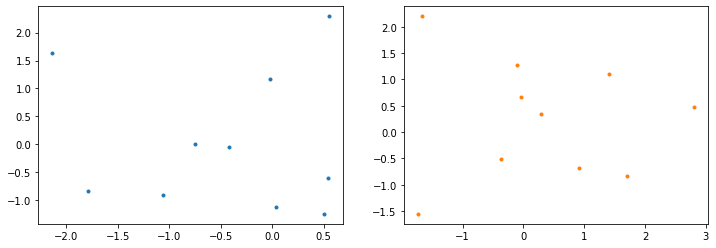

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(X[:,0], X[:,1], 'C0.')
plt.subplot(122)
plt.plot(X_[:,0], X_[:,1], 'C1.')